In [157]:
# We replicate Figure 1 from "Masked Autogressive FLow for Density Estimation" by Papamakarios et al.

In [158]:
import math
import types

import numpy as np
import scipy as sp
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import torch.utils.data

In [159]:
#####################################################################################

# In this cell we define the building blocks for the MAF.
# These implementations are taken from https://github.com/ikostrikov/pytorch-flows

#####################################################################################


def get_mask(in_features, out_features, in_flow_features, mask_type=None):

    if mask_type == 'input':
        in_degrees = torch.arange(in_features) % in_flow_features
    else:
        in_degrees = torch.arange(in_features) % (in_flow_features - 1)

    if mask_type == 'output':
        out_degrees = torch.arange(out_features) % in_flow_features - 1
    else:
        out_degrees = torch.arange(out_features) % (in_flow_features - 1)

    return (out_degrees.unsqueeze(-1) >= in_degrees.unsqueeze(0)).float()

class MaskedLinear(nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 mask,
                 cond_in_features=None,
                 bias=True):
        super(MaskedLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        if cond_in_features is not None:
            self.cond_linear = nn.Linear(
                cond_in_features, out_features, bias=False)

        self.register_buffer('mask', mask)

    def forward(self, inputs, cond_inputs=None):
        output = F.linear(inputs, self.linear.weight * self.mask,
                          self.linear.bias)
        if cond_inputs is not None:
            output += self.cond_linear(cond_inputs)
        return output


nn.MaskedLinear = MaskedLinear

#Masked Autoencoder for Density Estimation, i.e. matrix with zero-restrictions to
#ensure autogressive conditionals conditioned on one preceding data point and not all the rest.
class MADE(nn.Module):

    def __init__(self,
                 num_inputs,
                 num_hidden,
                 num_cond_inputs=None,
                 act='relu'):
        super(MADE, self).__init__()

        activations = {'relu': nn.ReLU, 'sigmoid': nn.Sigmoid, 'tanh': nn.Tanh}
        act_func = activations[act]

        input_mask = get_mask(
            num_inputs, num_hidden, num_inputs, mask_type='input')
        hidden_mask = get_mask(num_hidden, num_hidden, num_inputs)
        output_mask = get_mask(
            num_hidden, num_inputs * 2, num_inputs, mask_type='output')

        self.joiner = nn.MaskedLinear(num_inputs, num_hidden, input_mask,
                                      num_cond_inputs)

        self.trunk = nn.Sequential(act_func(),
                                   nn.MaskedLinear(num_hidden, num_hidden,
                                                   hidden_mask), act_func(),
                                   nn.MaskedLinear(num_hidden, num_inputs * 2,
                                                   output_mask))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            h = self.joiner(inputs, cond_inputs)
            m, a = self.trunk(h).chunk(2, 1)    #mu and alpha in Eq (4) MAF
            u = (inputs - m) * torch.exp(-a)
            return u, -a.sum(-1, keepdim=True)  

        else:
            x = torch.zeros_like(inputs)
            for i_col in range(inputs.shape[1]):
                h = self.joiner(x, cond_inputs)
                m, a = self.trunk(h).chunk(2, 1)
                x[:, i_col] = inputs[:, i_col] * torch.exp(
                    a[:, i_col]) + m[:, i_col]
            return x, -a.sum(-1, keepdim=True)


class Sigmoid(nn.Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            s = torch.sigmoid
            return s(inputs), torch.log(s(inputs) * (1 - s(inputs))).sum(
                -1, keepdim=True)
        else:
            return torch.log(inputs /
                             (1 - inputs)), -torch.log(inputs - inputs**2).sum(
                                 -1, keepdim=True)

# Helps in improving propagation of training signal in particular when working with very small minibatches.
class BatchNormFlow(nn.Module):
    
    def __init__(self, num_inputs, momentum=0.0, eps=1e-5):
        super(BatchNormFlow, self).__init__()

        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_inputs))
        self.register_buffer('running_var', torch.ones(num_inputs))

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            if self.training:
                self.batch_mean = inputs.mean(0)
                self.batch_var = (
                    inputs - self.batch_mean).pow(2).mean(0) + self.eps

                self.running_mean.mul_(self.momentum)
                self.running_var.mul_(self.momentum)

                self.running_mean.add_(self.batch_mean.data *
                                       (1 - self.momentum))
                self.running_var.add_(self.batch_var.data *
                                      (1 - self.momentum))

                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - mean) / var.sqrt()
            y = torch.exp(self.log_gamma) * x_hat + self.beta
            return y, (self.log_gamma - 0.5 * torch.log(var)).sum(
                -1, keepdim=True)
        else:
            if self.training:
                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)

            y = x_hat * var.sqrt() + mean

            return y, (-self.log_gamma + 0.5 * torch.log(var)).sum(
                -1, keepdim=True)

#Implements a shuffling layer 
class Shuffle(nn.Module):

    def __init__(self, num_inputs):
        super(Shuffle, self).__init__()
        self.perm = np.random.permutation(num_inputs)
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)


# Implements a Reverse layer
class Reverse(nn.Module):

    def __init__(self, num_inputs):
        super(Reverse, self).__init__()
        self.perm = np.array(np.arange(0, num_inputs)[::-1])
        self.inv_perm = np.argsort(self.perm)

    def forward(self, inputs, cond_inputs=None, mode='direct'):
        if mode == 'direct':
            return inputs[:, self.perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)
        else:
            return inputs[:, self.inv_perm], torch.zeros(
                inputs.size(0), 1, device=inputs.device)


# Implements forward and backward pass with computation of log Jacobians included.        
class FlowSequential(nn.Sequential):
    
    def forward(self, inputs, cond_inputs=None, mode='direct', logdets=None):
 
        self.num_inputs = inputs.size(-1)

        if logdets is None:
            logdets = torch.zeros(inputs.size(0), 1, device=inputs.device)

        assert mode in ['direct', 'inverse']
        if mode == 'direct':
            for module in self._modules.values():
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet
        else:
            for module in reversed(self._modules.values()):
                inputs, logdet = module(inputs, cond_inputs, mode)
                logdets += logdet

        return inputs, logdets

    def log_probs(self, inputs, cond_inputs = None):
        u, log_jacob = self(inputs, cond_inputs)
        log_probs = (-0.5 * u.pow(2) - 0.5 * math.log(2 * math.pi)).sum(
            -1, keepdim=True)
        return (log_probs + log_jacob).sum(-1, keepdim=True)

    def sample(self, num_samples=None, noise=None, cond_inputs=None):
        if noise is None:
            noise = torch.Tensor(num_samples, self.num_inputs).normal_()
        device = next(self.parameters()).device
        noise = noise.to(device)
        if cond_inputs is not None:
            cond_inputs = cond_inputs.to(device)
        samples = self.forward(noise, cond_inputs, mode='inverse')[0]
        return samples

In [160]:
# Defining the target distribution

# the density, figure 1a
def targetdensity(x1,x2):
    mu1 = 0, 
    sigma1=4
    mu2 = 1/4*x2*x2
    sigma2=1
    return 1/(sigma1 * np.sqrt(2 * np.pi)) * np.exp( - (x2 - mu1)**2 / (2 * sigma1**2) ) * 1/(sigma2 * np.sqrt(2 * np.pi)) * np.exp( - (x1 - mu2)**2 / (2 * sigma2**2) )
    
#draw samples from target distribution
def targetsampler(n):
    x2 = np.random.normal(0,4,n)
    x1 = np.random.normal(1/4*x2**2,1,n)
    return torch.t(torch.FloatTensor([x1,x2]))

In [161]:
# generate data

train_tensor = targetsampler(10000)
train_dataset = torch.utils.data.TensorDataset(train_tensor)

valid_tensor = targetsampler(10000)
valid_dataset = torch.utils.data.TensorDataset(valid_tensor)

test_tensor = targetsampler(10000)
test_dataset = torch.utils.data.TensorDataset(test_tensor)


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    drop_last=False)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False, 
    drop_last=False)#If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller.

In [162]:
# Setting parameter for Training figure 1b)
batch_size = 100
test_batch_size = 1000
epochs = 40
lr = 0.01 # learning rate
num_blocks = 1 # number of MADEs in MAF

num_inputs = 2 
num_hidden = 32

In [163]:
# Building the MAF for Training figure 1b)
modules = []
for _ in range(num_blocks):
        modules += [
            MADE(num_inputs, num_hidden), # zero-restricting the conditionals for ensuring autoregressive property of the flow.
            BatchNormFlow(num_inputs),    # rescaling and shifting for getting rid of covariate shifts, i.e. performance enhancing.
            Reverse(num_inputs)           # reverses the ordering of the dimensions, i.e. transforming the variables.
        ]

model = FlowSequential(*modules)

In [164]:
#training und validation routine figure 1b)
#uses Adaptive moment estimation for optimizing the update rule for the weights.
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

device = torch.device("cpu")
model.to(device)

def train(epoch):
    model.train()
    train_loss = 0

    for batch_idx, data in enumerate(train_loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        loss = -model.log_probs(data, cond_data).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 0

   
    with torch.no_grad():
        model(train_loader.dataset.tensors[0].to(data.device))


    for module in model.modules():
        if isinstance(module, BatchNormFlow):
            module.momentum = 1


def validate(epoch, model, loader, prefix='Validation'):
    model.eval()
    val_loss = 0

    for batch_idx, data in enumerate(loader):
        if isinstance(data, list):
            if len(data) > 1:
                cond_data = data[1].float()
                cond_data = cond_data.to(device)
            else:
                cond_data = None

            data = data[0]
        data = data.to(device)
        with torch.no_grad():
            val_loss += -model.log_probs(data, cond_data).sum().item()  # sum up batch loss

    return val_loss / len(loader.dataset)



In [165]:
#training figure 1 b)
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))

    train(epoch)
    validation_loss = validate(epoch, model, valid_loader)

    if epoch - best_validation_epoch >= 30:
        break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        best_model = copy.deepcopy(model)

    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))


validate(best_validation_epoch, best_model, test_loader, prefix='Test')


Epoch: 0
Best validation at epoch 0: Average Log Likelihood in nats: -5.5780

Epoch: 1
Best validation at epoch 0: Average Log Likelihood in nats: -5.5780

Epoch: 2
Best validation at epoch 0: Average Log Likelihood in nats: -5.5780

Epoch: 3
Best validation at epoch 0: Average Log Likelihood in nats: -5.5780

Epoch: 4
Best validation at epoch 0: Average Log Likelihood in nats: -5.5780

Epoch: 5
Best validation at epoch 5: Average Log Likelihood in nats: -5.5772

Epoch: 6
Best validation at epoch 5: Average Log Likelihood in nats: -5.5772

Epoch: 7
Best validation at epoch 7: Average Log Likelihood in nats: -5.5770

Epoch: 8
Best validation at epoch 7: Average Log Likelihood in nats: -5.5770

Epoch: 9
Best validation at epoch 7: Average Log Likelihood in nats: -5.5770

Epoch: 10
Best validation at epoch 7: Average Log Likelihood in nats: -5.5770

Epoch: 11
Best validation at epoch 7: Average Log Likelihood in nats: -5.5770

Epoch: 12
Best validation at epoch 7: Average Log Likelihood 

5.5906693359375

(-4, 4)

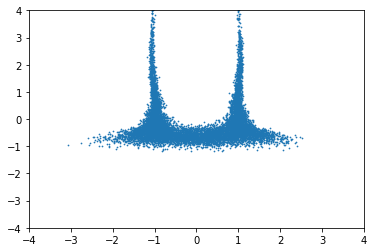

In [166]:
#Push training data through the best network in terms of log likelihood.
#like stated in the paper in section 3.1 the resulting points should be close to a gaussian distribution,
#if the model fits the target density well.

# As we can see below, this is not the case for a MAF with only one block
u = torch.t(best_model(train_tensor)[0].detach())
plt.scatter(u[0],u[1],s=0.5)
plt.xlim(-4,4)
plt.ylim(-4,4)


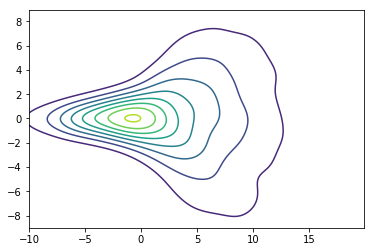

In [167]:
# Contour plot of the estimated density of the learned distribution
x = torch.t(best_model.sample(num_samples = 10000).detach())  # draw sample from learned distribution
kernel = scipy.stats.gaussian_kde(x) # kernel density estimation

x1 = np.arange(-10,20,0.1)
x2 = np.arange(-9,9,0.1)
X1, X2 = np.meshgrid(x1,x2)

X1 = X1.flatten()
X2 = X2.flatten()


Y=kernel.evaluate([X1,X2])
Y=np.reshape(Y,(-1,x1.shape[0]))
plt.contour(x1,x2,Y,10)

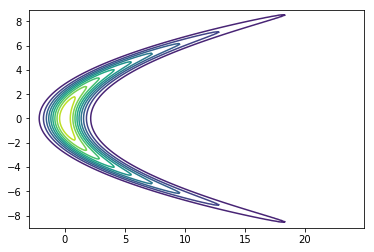

In [168]:
# Plot of target density to compare with the plot above
# As we can see, the learned density does not match the real density
x1 = np.arange(-3,25,0.1)
x2 = np.arange(-9,9,0.1)

X1, X2 = np.meshgrid(x1,x2)
Y = targetdensity(X1,X2)
plt.contour(X1,X2,Y,10)

In [169]:
# Now we repeat the experiment with a MAF with 5 layers instead of 1

# Setting parameter for Training figure 1c)
batch_size = 100
test_batch_size = 1000
epochs = 40
lr = 0.01 # learning rate
num_blocks = 5 # number of MADEs in MAF

num_inputs = 2 
num_hidden = 32

In [170]:
# Building the MAF for Training figure 1c)
modules = []
for _ in range(num_blocks):
        modules += [
            MADE(num_inputs, num_hidden), # zero-restricting the conditionals for ensuring autoregressive property of the flow.
            BatchNormFlow(num_inputs),    # rescaling and shifting for getting rid of covariate shifts, i.e. performance enhancing.
            Reverse(num_inputs)           # reverses the ordering of the dimensions, i.e. transforming the variables.
        ]

model = FlowSequential(*modules)

In [171]:
#uses Adaptive moment estimation for optimizing the update rule for the weights.
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

device = torch.device("cpu")
model.to(device)

#training figure 1 c)
best_validation_loss = float('inf')
best_validation_epoch = 0
best_model = model

for epoch in range(epochs):
    print('\nEpoch: {}'.format(epoch))

    train(epoch)
    validation_loss = validate(epoch, model, valid_loader)

    if epoch - best_validation_epoch >= 30:
        break

    if validation_loss < best_validation_loss:
        best_validation_epoch = epoch
        best_validation_loss = validation_loss
        best_model = copy.deepcopy(model)

    print(
        'Best validation at epoch {}: Average Log Likelihood in nats: {:.4f}'.
        format(best_validation_epoch, -best_validation_loss))


validate(best_validation_epoch, best_model, test_loader, prefix='Test')


Epoch: 0
Best validation at epoch 0: Average Log Likelihood in nats: -4.4369

Epoch: 1
Best validation at epoch 1: Average Log Likelihood in nats: -4.3272

Epoch: 2
Best validation at epoch 1: Average Log Likelihood in nats: -4.3272

Epoch: 3
Best validation at epoch 3: Average Log Likelihood in nats: -4.2670

Epoch: 4
Best validation at epoch 4: Average Log Likelihood in nats: -4.2653

Epoch: 5
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 6
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 7
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 8
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 9
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 10
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 11
Best validation at epoch 5: Average Log Likelihood in nats: -4.2403

Epoch: 12
Best validation at epoch 5: Average Log Likelihood 

4.235223876953125

(-4, 4)

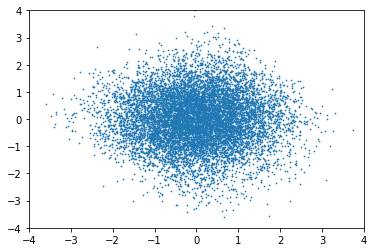

In [172]:
#Push training data through the best network in terms of log likelihood.
#like stated in the paper in section 3.1 the resulting points should be close to a gaussian distribution,
#if the model fits the target density well.

# As we can see below, this is the case for a MAF with 5 blocks
u = torch.t(best_model(train_tensor)[0].detach())
plt.scatter(u[0],u[1],s=0.5)
plt.xlim(-4,4)
plt.ylim(-4,4)

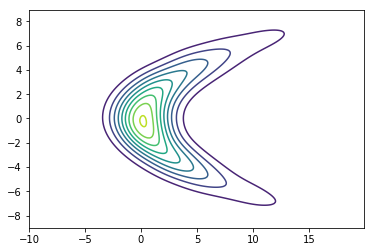

In [173]:
# Contour plot of the estimated density of the learned distribution
x = torch.t(best_model.sample(num_samples = 10000).detach())  # draw sample from learned distribution
kernel = scipy.stats.gaussian_kde(x) # kernel density estimation

x1 = np.arange(-10,20,0.1)
x2 = np.arange(-9,9,0.1)
X1, X2 = np.meshgrid(x1,x2)

X1 = X1.flatten()
X2 = X2.flatten()


Y=kernel.evaluate([X1,X2])
Y=np.reshape(Y,(-1,x1.shape[0]))
plt.contour(x1,x2,Y,10)

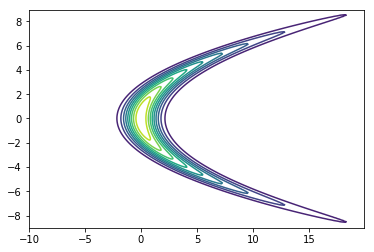

In [174]:
# Plot of target density to compare with the plot above
# As we can see, the learned density does match the real density now
x1 = np.arange(-10,20,0.1)
x2 = np.arange(-9,9,0.1)

X1, X2 = np.meshgrid(x1,x2)
Y = targetdensity(X1,X2)
plt.contour(X1,X2,Y,10)